# [EX 16] 다음에 볼 영화 예측하기

# 프로젝트: Movielens 영화 SBR

#### 평가 루브릭
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.  
데이터셋의 면밀한 분석을 토대로 <span style="color:red">세션단위 정의 과정(길이분석, 시간분석)</span>을 합리적으로 수행한 과정이 기술되었다.


2. RNN 기반의 예측 모델이 정상적으로 구성되어 <span style="color:red">안정적으로 훈련이 진행</span>되었다.  
적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.


3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.  
<span style="color:red">3가지 이상의 변화</span>를 시도하고 그 실험결과를 체계적으로 분석하였다.

# Pre-Step. 데이터 불러오기

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time'] # 해당 칼럼만 불러온다
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique() # 유니크한 id값이 몇개인지 확인

(6040, 3706)

In [5]:
session_length = data.groupby('UserId').size() # UserId를 기준으로 그룹화하여 크기를 확인
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
session_length.median(), session_length.mean() # 중간값과 평균값 확인

(96.0, 165.5975165562914)

In [7]:
session_length.min(), session_length.max() # 최소값과 최대값 확인

(20, 2314)

In [8]:
session_length.quantile(0.999) # 99.9%가 1343개 이하의 영화에 평가했다. 2314개를 평가한 id를 찾아보자

1343.181000000005

In [9]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session] # 큰 의미는 없는것 같다

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [10]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999] # 99.9% 까지의 갯수를 누적해서 확인.

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

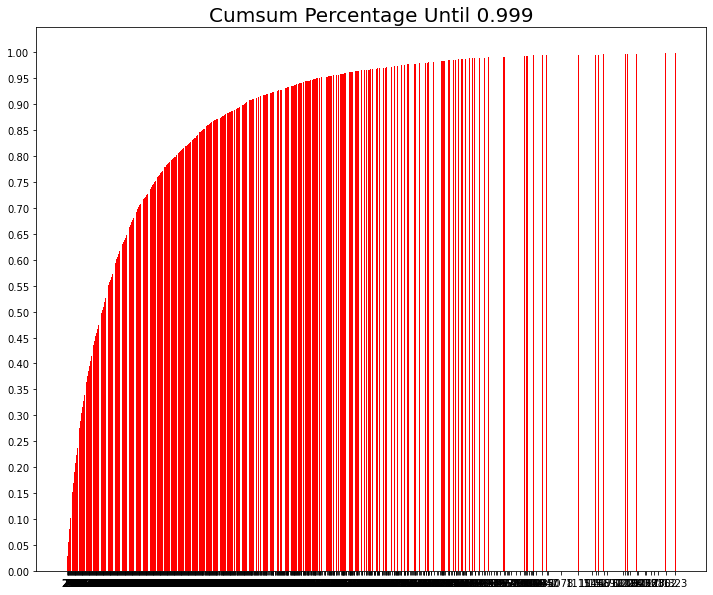

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red') # 누적합 그래프로 그려보자
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [12]:
from datetime import datetime
import time

data['Time'] = data['Time'].apply(lambda x: datetime.fromtimestamp(x)) # 1970년부터 경과한 시간 형태인 Time 칼럼을 datetime 형태로 바꿔준다
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [13]:
oldest, latest = data['Time'].min(), data['Time'].max() # 처음 시점과 끝 시점 출력
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [14]:
data['Time'].median() # 중간값 확인

Timestamp('2000-10-31 18:46:46')

In [15]:
data['Time'].quantile(0.9) # 누적합이 90%가 되는 값 확인

Timestamp('2000-12-29 23:42:56.400000')

In [16]:
data['Time'].quantile(0.1) # 10%가 되는 값 확인

Timestamp('2000-06-10 23:59:30')

In [ ]:
# 2000년도 데이터가 대부분이다.

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=50, least_click=100) # 100번이상 평가된 영화만 남기고, 50개 이상의 영화에 평가한 user만 남긴다
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [19]:
data = data[data['Rating'].apply(lambda x : x>=4)] # 선호한 데이터만 평가할 예정이므로 4, 5점을 준 데이터만 남긴다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


In [20]:
data = cleanse_recursive(data, shortest=10, least_click=100) # 오류다...50으로 한번 더 했어야 했는데 수정을 못했다.ㅜㅜ
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
3,1,3408,4,2000-12-31 22:04:35
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


# Step 2. 미니 배치의 구성

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [21]:
def split_by_date(data: pd.DataFrame, n_days: int): #날짜를 기준으로 데이터를 나눠준다
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [22]:
tr, test = split_by_date(data, n_days=30) # 최근부터 30일 까지를 test 데이터로 설정
tr, val = split_by_date(tr, n_days=100) # 30일부터 100일 까지를 val 데이터로 설정

In [23]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [24]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test') # test 데이터의 세션수가 75개 이므로 후에 배치 사이즈는 75보다 작게 해야 인퍼런스 오류가 나지 않을듯!

* train Set Stats Info
	 Events: 424443
	 Sessions: 3946
	 Items: 1278
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-10-20 04:05:05

* valid Set Stats Info
	 Events: 31672
	 Sessions: 169
	 Items: 1278
	 First Time : 2000-05-05 17:20:21
	 Last Time : 2003-01-29 03:00:40

* test Set Stats Info
	 Events: 17983
	 Sessions: 75
	 Items: 1276
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:08



In [25]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [26]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)
# 각각의 데이터를 pickle 파일로 저장해준다
tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 3. 모델 구성

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

In [27]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        
        return offsets

In [28]:
tr_dataset = SessionDataset(tr)
tr_dataset.df

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
3,1,3408,4,2000-12-31 22:04:35,4
...,...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27,111
999923,6040,232,5,2001-08-10 14:39:58,613
1000019,6040,2917,4,2001-08-10 14:40:29,689
999988,6040,1921,4,2001-08-10 14:41:04,191


In [29]:
tr_dataset.click_offsets # UserId 기준으로 각 Id 값의 시작 index 반환

array([     0,     43,    113, ..., 424173, 424259, 424443], dtype=int32)

In [30]:
tr_dataset.session_idx # 해당하는 session index를 반환

array([   0,    1,    2, ..., 3943, 3944, 3945])

In [31]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [32]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4) # 배치 사이즈를 4로 하고 데이터 확인
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
3,1,3408,4,2000-12-31 22:04:35,4
7,1,2804,5,2000-12-31 22:11:59,5
47,1,1207,4,2000-12-31 22:11:59,6
0,1,1193,5,2000-12-31 22:12:40,7
44,1,260,4,2000-12-31 22:12:40,8
9,1,919,4,2000-12-31 22:22:48,9


In [33]:
iter_ex = iter(tr_data_loader) #itertaror로 불러 하나씩 값을 확인해본다

In [34]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  43  49 134]
Label Item Idx are :       [  1  44 107   9]
Previous Masked Input Idx are []


In [35]:
tr_dataset.df.nunique()

UserId        3946
ItemId        1278
Rating           2
Time        240402
item_idx      1278
dtype: int64

In [36]:
def mrr_k(pred, truth: int, k: int): # MRR@k 구하는 함수 정의
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int: #Recall@k 구하는 함수 정의
    answer = truth in pred[:k]
    return int(answer)

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [38]:
def create_model(args): # 모델 생성 함수 정의
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [39]:
class Args: # 하이퍼파라미터를 클래스 형태로 정의
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [40]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 1278)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      199500    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 1278)                65178     
Total params: 264,678
Trainable params: 264,678
Non-trainable params: 0
_________________________________________________________________


In [41]:
print(args.batch_size)

64


# Step 4. 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [42]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [45]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Evaluation:  68%|██████▊   | 336/492 [01:52<00:52,  2.98it/s]


	 - Recall@20 epoch 1: 0.223633
	 - MRR@20    epoch 1: 0.056582



Evaluation:  68%|██████▊   | 336/492 [01:47<00:50,  3.12it/s]


	 - Recall@20 epoch 2: 0.272554
	 - MRR@20    epoch 2: 0.073331



Evaluation:  68%|██████▊   | 336/492 [01:46<00:49,  3.16it/s]

	 - Recall@20 epoch 3: 0.288830
	 - MRR@20    epoch 3: 0.080071



# Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [46]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  29%|██▉       | 82/279 [00:25<01:00,  3.27it/s]

	 - Recall@20: 0.325648
	 - MRR@20: 0.091603



# Step 7. 개선해보기

## (1) hidden size를 늘려보자

In [47]:
args1 = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model1 = create_model(args1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 1278)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    414000    
_________________________________________________________________
dropout_2 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_2 (Dense)              (64, 1278)                129078    
Total params: 543,078
Trainable params: 543,078
Non-trainable params: 0
_________________________________________________________________


In [48]:
train_model(model1, args1)

Evaluation:  68%|██████▊   | 336/492 [01:47<00:50,  3.11it/s]


	 - Recall@20 epoch 1: 0.255441
	 - MRR@20    epoch 1: 0.068490



Evaluation:  68%|██████▊   | 336/492 [01:46<00:49,  3.16it/s]


	 - Recall@20 epoch 2: 0.293806
	 - MRR@20    epoch 2: 0.081628



Evaluation:  68%|██████▊   | 336/492 [01:46<00:49,  3.17it/s]

	 - Recall@20 epoch 3: 0.303060
	 - MRR@20    epoch 3: 0.086153



## (2) batch 사이즈를 줄여보자

In [49]:
args2 = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model2 = create_model(args2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(16, 1, 1278)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      199500    
_________________________________________________________________
dropout_3 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (16, 1278)                65178     
Total params: 264,678
Trainable params: 264,678
Non-trainable params: 0
_________________________________________________________________


In [50]:
train_model(model2, args2)

Evaluation:  92%|█████████▏| 1819/1968 [03:25<00:16,  8.87it/s]


	 - Recall@20 epoch 1: 0.242578
	 - MRR@20    epoch 1: 0.063628



Evaluation:  92%|█████████▏| 1819/1968 [03:23<00:16,  8.93it/s]


	 - Recall@20 epoch 2: 0.271921
	 - MRR@20    epoch 2: 0.073840



Evaluation:  92%|█████████▏| 1819/1968 [03:20<00:16,  9.09it/s]

	 - Recall@20 epoch 3: 0.279893
	 - MRR@20    epoch 3: 0.078259



## (3) Learning rate를 조절해보자

In [51]:
args3 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20)
model3 = create_model(args3)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 1, 1278)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      199500    
_________________________________________________________________
dropout_4 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (64, 1278)                65178     
Total params: 264,678
Trainable params: 264,678
Non-trainable params: 0
_________________________________________________________________


In [52]:
train_model(model3, args3)

Evaluation:  68%|██████▊   | 336/492 [01:48<00:50,  3.10it/s]


	 - Recall@20 epoch 1: 0.260882
	 - MRR@20    epoch 1: 0.069492



Evaluation:  68%|██████▊   | 336/492 [01:47<00:50,  3.11it/s]


	 - Recall@20 epoch 2: 0.264416
	 - MRR@20    epoch 2: 0.071601



Evaluation:  68%|██████▊   | 336/492 [01:48<00:50,  3.09it/s]

	 - Recall@20 epoch 3: 0.263858
	 - MRR@20    epoch 3: 0.071249



## (4) hidden size를 늘리고, batch 사이즈를 줄여보자

In [53]:
args4 = Args(tr, val, test, batch_size=16, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model4 = create_model(args4)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(16, 1, 1278)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 100), (16, 100)]    414000    
_________________________________________________________________
dropout_5 (Dropout)          (16, 100)                 0         
_________________________________________________________________
dense_5 (Dense)              (16, 1278)                129078    
Total params: 543,078
Trainable params: 543,078
Non-trainable params: 0
_________________________________________________________________


In [54]:
train_model(model4, args4)

Evaluation:  92%|█████████▏| 1819/1968 [03:23<00:16,  8.92it/s]


	 - Recall@20 epoch 1: 0.257559
	 - MRR@20    epoch 1: 0.070178



Evaluation:  92%|█████████▏| 1819/1968 [03:24<00:16,  8.90it/s]


	 - Recall@20 epoch 2: 0.281267
	 - MRR@20    epoch 2: 0.078689



Evaluation:  92%|█████████▏| 1819/1968 [03:22<00:16,  8.98it/s]

	 - Recall@20 epoch 3: 0.286284
	 - MRR@20    epoch 3: 0.080405



### 결과 확인

기본 모델에서 하나씩만 변경하여 결과 확인

(1) batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20  
* hsz: 50 -> 100

In [55]:
test_model(model1, args1, test)

Evaluation:  29%|██▉       | 82/279 [00:26<01:03,  3.11it/s]

	 - Recall@20: 0.335747
	 - MRR@20: 0.097565



(2) batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20
* batch_size: 64 -> 16

In [56]:
test_model(model2, args2, test)

Evaluation:  89%|████████▊ | 992/1119 [01:51<00:14,  8.86it/s]

	 - Recall@20: 0.254410
	 - MRR@20: 0.071833



(3) batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20
* lr: 0.001 -> 0.01

In [57]:
test_model(model3, args3, test)

Evaluation:  29%|██▉       | 82/279 [00:26<01:03,  3.10it/s]

	 - Recall@20: 0.292302
	 - MRR@20: 0.077872



(4) batch_size=16, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20
* hsz: 50 -> 100
* batch_size: 64 -> 16

In [58]:
test_model(model4, args4, test)

Evaluation:  89%|████████▊ | 992/1119 [01:54<00:14,  8.68it/s]

	 - Recall@20: 0.260081
	 - MRR@20: 0.073774



#### 결과로 Recall@20과 MRR@20을 비교해보자.(Recall@20 / MRR@20)
* Recall@20: 20개의 추천된 결과 중 관련성있는 결과가 몇 개인지?
* MRR@20: 20개의 추천된 결과 중 관련성있는 결과가 몇 번째에 있는지의 역수

\# 기본모델 batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20
-> 0.325648 / 0.091603

(1) batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20  
* hsz: 50 -> 100
-> 0.335747 / 0.097565

(2) batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20
* batch_size: 64 -> 16
-> 0.254410 / 0.071833

(3) batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20
* lr: 0.001 -> 0.01
-> 0.292302 / 0.077872

(4) batch_size=16, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20
* hsz: 50 -> 100
* batch_size: 64 -> 16
-> 0.260081 / 0.073774

#### 결론
* 기본적으로, epoch를 3으로 제한했기에 학습이 제대로 이루어지지 않았을 것이다.  
그럼에도 하이퍼파라미터의 값을 변화시키면 어떤 경향이 보일것이라 생각했다.  
* 기본 모델보다 성능이 좋은 결과는 (1) 뿐이다. 단순히 히든사이즈만 두 배로 높여줬지만 Recall@20과 MRR@20 모두 약간 상승하는 모습니다.
* 다른 시도에서는 오히려 성능이 떨어졌다. 특히나 Recall@20 값이 많이 떨어졌다.

---
---

# 회고
* 아직도 학습을 위한 코드에서 이해가 안되는 부분들이 존재한다. 앞으로의 task들을 위해 하루 빨리 이해해야한다.
* 너무 느린 속도로 인해 epoch을 3번만 돌린것이 아쉽다. 하루종일 켜놓을수만 있다면 더 많이 시도해봤을텐데 그러지 못했다. 로컬 환경이 매우 안좋은 상황이라 시스템적인 부분이 아쉽다.
* 하이퍼파라미터 조절만으로는 의미있는만큼의 큰 변화를 예상하기 어렵다. 네트워크 구조나 데이터 분석 과정이 더 큰 관여를 할 것이다.